In [144]:
import pandas as pd
import pickle
from os.path import expanduser
from collections import Counter
import spacy
nlp = spacy.load("es_core_news_sm")

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from catboost import CatBoostRegressor


---
## Load the data

In [234]:
filename = expanduser("/Users/yenphan/Downloads/630_Advanced_ML/ML_Project/train.pickle")
with open(filename,'rb') as f:
    data = pickle.load(f, encoding='utf-8')

In [235]:
df = pd.DataFrame(data)
df.head(3)

price                                              title  \
0  320.000 €  Piso Tallers. Piso con 2 habitaciones con asce...   
1  335.000 €  Piso C/ de valència. Piso reformado en venta d...   
2  330.000 €  Piso en Dreta de l´Eixample. Acogedor piso al ...   

                        loc_string   loc                             features  \
0          Barcelona - Sant Antoni  None  [85 m2, 2 hab., 1 baño, 3.647 €/m2]   
1  Barcelona - Dreta de l´Eixample  None  [65 m2, 2 hab., 1 baño, 5.000 €/m2]   
2  Barcelona - Dreta de l´Eixample  None  [77 m2, 2 hab., 1 baño, 4.286 €/m2]   

   type subtype     selltype  \
0  FLAT    FLAT  SECOND_HAND   
1  FLAT    FLAT  SECOND_HAND   
2  FLAT    FLAT  SECOND_HAND   

                                                desc  
0  Piso en última planta a reformar en calle Tall...  
1  Ubicado en la zona del Camp de l’Arpa, cerca d...  
2  En pleno centro de Barcelona, justo al lado de...

In [236]:
df.describe()

price                                              title  \
count         866                                                866   
unique        186                                                800   
top     350.000 €  Piso Carrer de la marina. Piso con 2 habitaciones   
freq           37                                                  5   

                         loc_string                      loc  \
count                           866                       92   
unique                           18                       88   
top     Barcelona - Sagrada Família  Carrer de Viladomat 297   
freq                            163                        2   

                                   features  type subtype     selltype  \
count                                   866   866     866          866   
unique                                  735     7       7            1   
top     [75 m2, 2 hab., 1 baño, 3.999 €/m2]  FLAT    FLAT  SECOND_HAND   
freq                                     17   806     806          866   

                                                     desc  
count                                                 866  
unique                                                853  
top     La Casa Agency presenta:\nVIVIENDA EN LA ZONA ...  
freq                                                    6

---
## Basic cleaning:
- "price": remove €
- "type" & "subtype": same columns -> delete one
- "loc": too many null values -> remove
- "features": remove "€/m2", only keep m2, bathroom and bedrome (since we dont have price for test set)

In [237]:
def process_features(features_list):
    square_meter = None
    bedroom = None
    bathroom = None
    Euro_m2 = None

    for feature in features_list:
        if 'm2' in feature and square_meter is None:
            square_meter = int(feature.split()[0])
        elif 'hab.' in feature and bedroom is None:
            bedroom = int(feature.split()[0])
        elif 'baño' in feature and bathroom is None:
            bathroom = int(feature.split()[0])
        elif '€/m2' in feature and Euro_m2 is None:
            Euro_m2 = float(feature.split()[0].replace('.', '').replace(',', '.'))

    return square_meter, bedroom, bathroom, Euro_m2

df[['square_meter', 'bedroom', 'bathroom', 'Euro_m2']] = df.apply(lambda row: process_features(row['features']), axis=1, result_type='expand')

# Clean "price" column
df['price'] = df['price'].str.replace(' €', '').str.replace('.', '').astype(int)

# Remove "Barcelona" in locaton column
df['loc_string'] = df['loc_string'].str.replace('Barcelona - ', '')

# Drop non-used columns
df.drop(['title', 'loc', 'features', 'subtype','selltype', 'Euro_m2'], axis=1, inplace=True)

df = df.dropna()
df.head(5)

df

/var/folders/z0/1j3jjj4961l_pl7k7vwpyfs80000gn/T/ipykernel_30462/3558986012.py:22: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price'] = df['price'].str.replace(' €', '').str.replace('.', '').astype(int)


price           loc_string  type  \
0    320000          Sant Antoni  FLAT   
1    335000  Dreta de l´Eixample  FLAT   
2    330000  Dreta de l´Eixample  FLAT   
3    435000          Sant Antoni  FLAT   
4    410000      Sagrada Família  FLAT   
..      ...                  ...   ...   
861  342000                Navas  FLAT   
862  315000                Navas  FLAT   
863  360000                Navas  FLAT   
864  270000                Navas  FLAT   
865  225000                Navas  FLAT   

                                                  desc  square_meter  bedroom  \
0    Piso en última planta a reformar en calle Tall...          85.0      2.0   
1    Ubicado en la zona del Camp de l’Arpa, cerca d...          65.0      2.0   
2    En pleno centro de Barcelona, justo al lado de...          77.0      2.0   
3    Vivienda espaciosa en Sant Antoni, cerca de Pl...          96.0      3.0   
4    En el corazón de Barcelona, en una hermosa fin...          84.0      2.0   
..                                                 ...           ...      ...   
861  HANNAN-PIPER Real Estate les presenta, en excl...         115.0      3.0   
862  ¡ OPORTUNIDAD !\n\nLa Casa Agency vende: Vivie...          82.0      3.0   
863  Piso totalmente REFORMADO y a ESTRENAR, con MU...          79.0      4.0   
864  Presentamos la oportunidad de comprar un bonit...          63.0      1.0   
865  Piso de 80 metros totalmente reformado en Sagr...          80.0      2.0   

     bathroom  
0         1.0  
1         1.0  
2         1.0  
3         2.0  
4         1.0  
..        ...  
861       1.0  
862       1.0  
863       2.0  
864       1.0  
865       1.0  

[856 rows x 7 columns]

In [238]:
df.describe()

price  square_meter     bedroom    bathroom
count     856.000000    856.000000  856.000000  856.000000
mean   344400.419393     80.653037    2.746495    1.426402
std     76346.655117     20.954307    1.192564    0.522436
min     90000.000000     13.000000    1.000000    1.000000
25%    297875.000000     66.000000    2.000000    1.000000
50%    349000.000000     80.000000    3.000000    1.000000
75%    400000.000000     93.250000    3.000000    2.000000
max    500000.000000    178.000000   22.000000    4.000000

In [239]:
count_bedrooms_ountliner = df[df['bedroom'] > 5].shape[0]
count_square_meter_ountliner = df[df['square_meter'] < 20.000000].shape[0]
count_bedrooms_ountliner, count_square_meter_ountliner

(2, 1)

In [240]:
#drop square_meter < 20 (count = 1)
#drop bedroom >5 (count = 1)

df = df[df['bedroom'] <= 5]
df = df[df['square_meter'] >= 20.000000]

df = df.reset_index(drop=True)
df.describe()


price  square_meter     bedroom    bathroom
count     853.000000    853.000000  853.000000  853.000000
mean   344837.935522     80.704572    2.722157    1.427902
std     75861.595385     20.848648    0.987689    0.522741
min    120000.000000     24.000000    1.000000    1.000000
25%    298000.000000     66.000000    2.000000    1.000000
50%    349000.000000     80.000000    3.000000    1.000000
75%    400000.000000     93.000000    3.000000    2.000000
max    500000.000000    178.000000    5.000000    4.000000

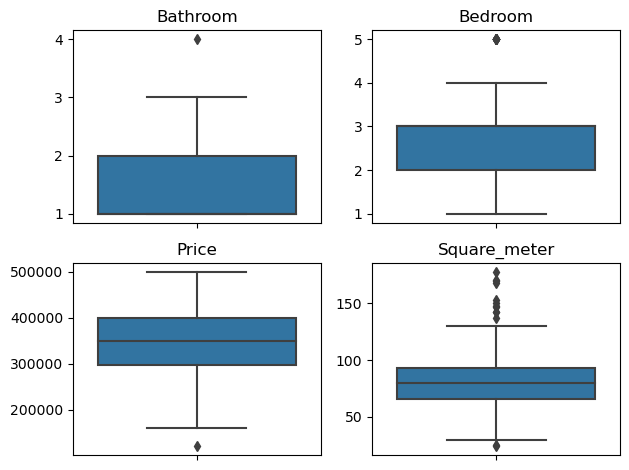

In [241]:
columns_to_plot = ['bathroom', 'bedroom', 'price', 'square_meter']

for i, column in enumerate(columns_to_plot):
    plt.subplot(2, 2, i+1)
    sns.boxplot(y=df[column])
    plt.title(column.capitalize())
    plt.ylabel('')

plt.tight_layout()
plt.show()


---
## 1. Using spaCy to 
- (1) Tokenize and 
- (2) Lemmatize the data

In [242]:
df2 = df.copy()

In [243]:
import spacy

nlp = spacy.load("es_core_news_sm")

# Function to process text: lowercase, remove stop words, punctuation, and special characters
def process_text(text):
    text = text.replace("\n\n", " ")
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc
        if not token.is_punct
        and not token.is_stop
        and token.is_alpha  # Ensure the token is alphabetic to remove numbers and special characters
    ]
    return tokens

df2['processed_desc'] = df2['desc'].apply(process_text)

In [245]:

# all_tokens = [token for tokens_list in df2['processed_desc'] for token in tokens_list]

# # Filter out the stop words
# filtered_tokens = [token for token in all_tokens if token not in real_estate_stopwords_spanish]

# # Use Counter to create a frequency distribution of the remaining tokens
# token_counts = Counter(filtered_tokens)

# # Get the most common tokens
# top_tokens = token_counts.most_common() 

# print(top_tokens[:100])


In [246]:
real_estate_stopwords_spanish = [
    "área", "provincia", "ubicación", "parcela", "hectárea", "m²", "m2", "cuadrado", "venta", "cuadrado", "metro", "dormitorio", "baño","cuarto",
    "sala", "cocina", "pasillo", "corredor", "comedor", "piscina", "apartamento", "piso", "precio", "barcelona", "barrio",
    "inmobiliaria", "habitación", "distrito",
    "piso", "baño", "zona", "habitación", "doble", "salón", "finca", "completo",
    "calle", "planta", "dormitorio", "precio", "ciudad", "salida",
    "suelo", "ofrecer", "aire", "acondicionado", "constar", "espacio", "ubicado",
    "minuto", "independiente", "tipo", "visita", "línea", "distribuido", "ubicación",
    "construido", "real", "año", "comunicado", "vender", "entrar", "incluido",
    "honorario", "posibilidad", "orientación", "desear", "agencia",
    "totalmente", "incluir", "información", "eixample", "finco", "principal", "altura",
    "abierto", "gas", "antoni", "parada", "apartamento", "manzana", "inmobiliario",
    "empotrado", "puerta", "sagrada", "cercano", "cuarto", "hogar", "asesoramiento",
    "superficie", "estancia", "aseo", "orientado", "actualmente", "esquerra", "mercado",
    "buscar", "compromiso", "comunicación", "distrito", "comunitario", "distribuir",
    "compra", "compraventa", "agency", "bomba", "pau", "dudar", "departamento",
    "permitir", "paso", "necesidad", "valoración", "disponer", "encontrar", "vivir", "impuesto", "colegio", "plato", "i", "distribución", 
    "bañera", "carpinteer", "vida", "americano", "lugar", "necesario", "obra", "acceder", 
    "listo", "propietario", "proceder", "escaso", "sur", "oferta", "pie", "gr", "ver él", 
    "característica", "detalle", "itp", "proceso", "pieza", "estar", "visto", "visitar él", 
    "gestión", "amb", "notarial", "escrituración", "podrás", "contactar", "cc", "gracias", 
    "poder", "intermediación", "comprar", "condición", "mediano", "diagonal", "nivel", "venir", 
    "perder", "registral", "españa", "registro", "climalit", "comprador", "vecino", "martí", 
    "contacto", "hora", "expuesto", "proyecto", "material", "actual", "noche", "integrado", "opción", 
    "pienc", "emblemático", "disposición", "visitar", "and", "m", "instalación", "caminar", 
]

In [247]:
important_words = [
    "hermoso", "encantador", "precioso", "elegante",
    "lujoso", "opulento", "exquisito", "suntuoso",
    "mar", "océano", "agua", "costa",
    "vista", "panorámica", "paisaje", "perspectiva",
    "océano", "mar", "agua", "vasto",
    "espacioso", "amplio", "grande", "extenso",
    "villa", "residencia", "mansión", "casa",
    "grande", "enorme", "amplio", "vasto",
    "playa", "costa", "orilla", "arena",
    "terraza", "balcón", "azotea", "patio",
    "jardín", "parque", "huerto", "césped",
    "privado", "personal", "íntimo", "reservado",
    "tranquilo", "sereno", "pacífico", "apacible",
    "nuevo", "reciente", "moderno", "fresco",
    "complejo", "conjunto", "complejidad", "conjunto residencial",
    "golf", "campo de golf", "golfista", "hoyo",
    "ocio", "recreo", "entretenimiento", "diversión",
    "disfrutar", "gozar", "deleitarse", "aprovechar",
    "ideal", "perfecto", "óptimo", "idóneo",
    "genial", "fantástico", "estupendo", "magnífico",
    "ático", "último piso", "ático dúplex", "terraza superior",
    "bonito", "agradable", "bonito", "bello",
    "alto", "elevado", "alto", "grande",
    "estándar", "normal", "convencional", "regular",
    "fantástico", "maravilloso", "asombroso", "increíble"
]

def process_description(desc, stop_words, important_words, boost_factor):
    # Remove stop words and boost important words
    processed_tokens = []
    for word in desc:
        if word in important_words:
            # Boost important words
            processed_tokens.extend([word] * boost_factor)
        elif word not in stop_words:
            # Keep words that are not in stop words
            processed_tokens.append(word)
    return processed_tokens

# Apply the function to the 'processed_desc' column
df2['boosted_processed_desc'] = df2['processed_desc'].apply(
    lambda desc: process_description(desc, real_estate_stopwords_spanish, important_words, boost_factor=5)
)


---
## Start training model with CatBoostRegressor

In [248]:
df3 = df2.copy()

X = df3.drop('price', axis=1)
y = df3['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [212]:
# Custom transformer to convert lists to strings
class ListToStringTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Define different transformers for different types of features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Define preprocessor with transformers for numerical, categorical, and text features
numerical_features = ['square_meter', 'bedroom', 'bathroom']
categorical_features = ['type']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features), 
        ('desc', Pipeline([
            ('list_to_string', ListToStringTransformer()),  # Convert list of words to string
            ('tfidf', TfidfVectorizer(max_features=200, max_df=.75, min_df=4))  # Apply TF-IDF
        ]), 'boosted_processed_desc'),
        ('loc_string_tfidf', TfidfVectorizer(max_features=50, max_df=.75, min_df=4), 'loc_string')  # Apply TF-IDF to 'loc_string'
    ]
)

# # Define the pipeline
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('regressor', GradientBoostingRegressor(random_state=30, n_estimators=300)),
# ])


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(random_state=30))
])


# Fit the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
predictions = pipeline.predict(X_test)


Learning rate set to 0.038541
0:	learn: 74509.6560241	total: 60.7ms	remaining: 1m
1:	learn: 73709.7170767	total: 64.9ms	remaining: 32.4s
2:	learn: 72774.2320690	total: 70.2ms	remaining: 23.3s
3:	learn: 71864.1058334	total: 73.2ms	remaining: 18.2s
4:	learn: 70968.6364834	total: 77.4ms	remaining: 15.4s
5:	learn: 70183.8827747	total: 82.8ms	remaining: 13.7s
6:	learn: 69391.7479472	total: 85.7ms	remaining: 12.2s
7:	learn: 68564.3790790	total: 88ms	remaining: 10.9s
8:	learn: 67938.3489626	total: 89.9ms	remaining: 9.9s
9:	learn: 67193.1173890	total: 92.6ms	remaining: 9.16s
10:	learn: 66304.9751351	total: 94.7ms	remaining: 8.52s
11:	learn: 65751.2739498	total: 97.3ms	remaining: 8.01s
12:	learn: 65140.3942488	total: 99.6ms	remaining: 7.56s
13:	learn: 64535.1729866	total: 102ms	remaining: 7.16s
14:	learn: 63970.9476863	total: 104ms	remaining: 6.82s
15:	learn: 63321.6298443	total: 106ms	remaining: 6.52s
16:	learn: 62820.9045596	total: 108ms	remaining: 6.25s
17:	learn: 62202.5453311	total: 110ms	

In [214]:
from sklearn.model_selection import GridSearchCV

# Define a range of hyperparameters for the grid search
param_grid = {
    'regressor__iterations': [500, 1000, 1500],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__depth': [4, 6, 8]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# grid_search.best_params_ contains the best found parameters


0:	learn: 75201.0513995	total: 57.7ms	remaining: 28.8s
1:	learn: 74982.3819412	total: 58.6ms	remaining: 14.6s
2:	learn: 74758.4655572	total: 60.1ms	remaining: 9.95s
0:	learn: 76263.6829387	total: 55.3ms	remaining: 27.6s
3:	learn: 74513.6852492	total: 61.9ms	remaining: 7.68s
1:	learn: 75985.2657831	total: 56.4ms	remaining: 14s
4:	learn: 74282.1509528	total: 63.3ms	remaining: 6.26s
2:	learn: 75754.4133508	total: 58ms	remaining: 9.61s
5:	learn: 74042.1467682	total: 64.9ms	remaining: 5.34s
3:	learn: 75465.7755306	total: 59.3ms	remaining: 7.35s
0:	learn: 75052.6164052	total: 57ms	remaining: 28.4s
4:	learn: 75206.6542740	total: 60.7ms	remaining: 6s
6:	learn: 73808.2316585	total: 67.5ms	remaining: 4.75s
1:	learn: 73740.6781935	total: 59.7ms	remaining: 14.9s
5:	learn: 74940.4763602	total: 62.1ms	remaining: 5.12s
0:	learn: 74491.4737621	total: 58.1ms	remaining: 29s
2:	learn: 72710.3202518	total: 61.3ms	remaining: 10.2s
7:	learn: 73592.3789749	total: 70ms	remaining: 4.3s
0:	learn: 75188.5976034	

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['square_meter',
                                                                          'bedroom',
                                                                          'bathroom']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['type']),
                                                                        ('desc',
                                                                         Pipeline(steps=[('list_to_string',
                                                                                          ListToStringTransformer()),
                                                                                         ('tfidf',
                                                                                          TfidfVectorizer(max_df=0.75,
                                                                                                          max_features=200,
                                                                                                          min_df=4))]),
                                                                         'boosted_processed_desc'),
                                                                        ('loc_string_tfidf',
                                                                         TfidfVectorizer(max_df=0.75,
                                                                                         max_features=50,
                                                                                         min_df=4),
                                                                         'loc_string')])),
                                       ('regressor',
                                        <catboost.core.CatBoostRegressor object at 0x2b73ca490>)]),
             n_jobs=-1,
             param_grid={'regressor__depth': [4, 6, 8],
                         'regressor__iterations': [500, 1000, 1500],
                         'regressor__learning_rate': [0.01, 0.05, 0.1]})

In [215]:
grid_search.best_params_

{'regressor__depth': 8,
 'regressor__iterations': 500,
 'regressor__learning_rate': 0.1}

In [216]:
grid_search.best_score_

0.6287186604807772

---
## Test

In [262]:
filename = expanduser("/Users/yenphan/Downloads/630_Advanced_ML/ML_Project/test_kaggle.pickle")
with open(filename,'rb') as f:
    test = pickle.load(f, encoding='utf-8')

In [263]:
df_test = pd.DataFrame(test)
df_test.head(3)

title  \
0  Piso Carrer de llull. Piso con 4 habitaciones ...   
1  Piso Diagonal. Luminoso piso de 4 habitaciones...   
2  Piso Carrer del consell de cent. Piso amueblad...   

                                      loc_string   loc  \
0  Barcelona - El Parc i la Llacuna del Poblenou  None   
1                           Barcelona - Poblenou  None   
2    Barcelona - L´Antiga Esquerra de l´Eixample  None   

                  features                                        description  \
0  [87 m2, 4 hab., 1 baño]  Contactar con Camila 7. 3. La Casa Agency Estu...   
1  [78 m2, 4 hab., 1 baño]  ¡Un gran piso a reformar es una gran oportunid...   
2  [65 m2, 1 hab., 1 baño]  AUREA INMOBILIARIA PRESENTA, ACOGEDOR APARTAME...   

   type subtype     selltype  \
0  FLAT    FLAT  SECOND_HAND   
1  FLAT    FLAT  SECOND_HAND   
2  FLAT    FLAT  SECOND_HAND   

                                                desc  id  
0  Contactar con Camila 7. 3.\n\nLa Casa Agency E...   0  
1  ¡Un gran piso a reformar es una gran oportunid...   1  
2  AUREA INMOBILIARIA PRESENTA, ACOGEDOR APARTAME...   2

In [264]:
df_test[['square_meter', 'bedroom', 'bathroom', 'Euro_m2']] = df_test.apply(lambda row: process_features(row['features']), axis=1, result_type='expand')
df_test['loc_string'] = df_test['loc_string'].str.replace('Barcelona - ', '')

# Drop non-used columns
df_test.drop(['title', 'loc', 'features', 'subtype','selltype', 'Euro_m2', 'id'], axis=1, inplace=True)

df_test = df_test.dropna()
df_test.head(3)

df_test

loc_string  \
0    El Parc i la Llacuna del Poblenou   
1                             Poblenou   
2      L´Antiga Esquerra de l´Eixample   
3                             Poblenou   
4                          Sant Antoni   
..                                 ...   
127                Dreta de l´Eixample   
128  El Parc i la Llacuna del Poblenou   
129                    Sagrada Família   
130                           Poblenou   
131  El Parc i la Llacuna del Poblenou   

                                           description       type  \
0    Contactar con Camila 7. 3. La Casa Agency Estu...       FLAT   
1    ¡Un gran piso a reformar es una gran oportunid...       FLAT   
2    AUREA INMOBILIARIA PRESENTA, ACOGEDOR APARTAME...       FLAT   
3    Piso en pleno centro de Poblenou, techos altos...       FLAT   
4    Punt Zona Franca presenta esta fantástica vivi...       FLAT   
..                                                 ...        ...   
127  Piso totalmente exterior con balcón, a 2 calle...       FLAT   
128  Estupenda oportunidad en el Parc i La Llacuna ...       FLAT   
129  ¡OPORTUNIDAD EN SAGRADA FAMILIA! Piso situado ...       FLAT   
130  Piso en venta, Barcelona, Poblenou, carrer del...  APARTMENT   
131  Oportunidad Única Inversión Barcelona! Piso 10...       FLAT   

                                                  desc  square_meter  bedroom  \
0    Contactar con Camila 7. 3.\n\nLa Casa Agency E...          87.0      4.0   
1    ¡Un gran piso a reformar es una gran oportunid...          78.0      4.0   
2    AUREA INMOBILIARIA PRESENTA, ACOGEDOR APARTAME...          65.0      1.0   
3    Piso en pleno centro de Poblenou, techos altos...          88.0      3.0   
4    Punt Zona Franca presenta esta fantástica vivi...          82.0      2.0   
..                                                 ...           ...      ...   
127  Encantador piso alto todo exterior con 2 balco...          89.0      3.0   
128  Estupenda oportunidad en el Parc i La Llacuna ...          65.0      3.0   
129  ¡OPORTUNIDAD EN SAGRADA FAMILIA!\n\nPiso situa...          75.0      4.0   
130  Piso en venta, Barcelona, Poblenou, carrer del...          75.0      3.0   
131  Oportunidad Única Inversión Barcelona! Piso 10...          80.0      4.0   

     bathroom  
0         1.0  
1         1.0  
2         1.0  
3         1.0  
4         1.0  
..        ...  
127       1.0  
128       1.0  
129       1.0  
130       2.0  
131       2.0  

[132 rows x 7 columns]

In [265]:
df_test['processed_desc'] = df_test['desc'].apply(process_text)
df_test['boosted_processed_desc'] = df_test['processed_desc'].apply(
    lambda desc: process_description(desc, real_estate_stopwords_spanish, important_words, boost_factor=5)
)
df_test.head()

loc_string  \
0  El Parc i la Llacuna del Poblenou   
1                           Poblenou   
2    L´Antiga Esquerra de l´Eixample   
3                           Poblenou   
4                        Sant Antoni   

                                         description  type  \
0  Contactar con Camila 7. 3. La Casa Agency Estu...  FLAT   
1  ¡Un gran piso a reformar es una gran oportunid...  FLAT   
2  AUREA INMOBILIARIA PRESENTA, ACOGEDOR APARTAME...  FLAT   
3  Piso en pleno centro de Poblenou, techos altos...  FLAT   
4  Punt Zona Franca presenta esta fantástica vivi...  FLAT   

                                                desc  square_meter  bedroom  \
0  Contactar con Camila 7. 3.\n\nLa Casa Agency E...          87.0      4.0   
1  ¡Un gran piso a reformar es una gran oportunid...          78.0      4.0   
2  AUREA INMOBILIARIA PRESENTA, ACOGEDOR APARTAME...          65.0      1.0   
3  Piso en pleno centro de Poblenou, techos altos...          88.0      3.0   
4  Punt Zona Franca presenta esta fantástica vivi...          82.0      2.0   

   bathroom                                     processed_desc  \
0       1.0  [contactar, camila, casa, agency, estudio, mir...   
1       1.0  [piso, reformar, oportunidad, ideal, inversión...   
2       1.0  [aurea, inmobiliario, presento, acogedor, apar...   
3       1.0  [piso, pleno, centro, poblenou, techo, alto, o...   
4       1.0  [punt, zona, franco, presentar, fantástico, vi...   

                              boosted_processed_desc  
0  [camila, casa, casa, casa, casa, casa, miraflo...  
1  [reformar, oportunidad, ideal, ideal, ideal, i...  
2  [aurea, presento, acogedor, consejo, ciento, p...  
3  [pleno, centro, poblenou, techo, alto, alto, a...  
4  [punt, franco, presentar, fantástico, fantásti...

In [266]:
df_test['loc_string'] = df_test['loc_string'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Custom transformer to convert lists to strings (if not already done)
class ListToStringTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

best_params = {
    'depth': 8,
    'iterations': 500,
    'learning_rate': 0.1
}

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(random_state=30, **best_params))
])

pipeline.fit(X, y)

predictions = pipeline.predict(df_test)

0:	learn: 73091.8976481	total: 13.8ms	remaining: 6.87s
1:	learn: 70523.4764461	total: 27.1ms	remaining: 6.76s
2:	learn: 68264.1601651	total: 33.2ms	remaining: 5.51s
3:	learn: 66448.5588565	total: 39.5ms	remaining: 4.9s
4:	learn: 64780.1691700	total: 45.9ms	remaining: 4.54s
5:	learn: 63113.8034525	total: 52.1ms	remaining: 4.29s
6:	learn: 61854.4373749	total: 58ms	remaining: 4.08s
7:	learn: 60331.5933023	total: 64.6ms	remaining: 3.97s
8:	learn: 59602.1815731	total: 70.9ms	remaining: 3.87s
9:	learn: 58107.3112220	total: 78.1ms	remaining: 3.83s
10:	learn: 57120.2244834	total: 84.5ms	remaining: 3.76s
11:	learn: 56051.9739988	total: 90.9ms	remaining: 3.7s
12:	learn: 54943.4123681	total: 97.4ms	remaining: 3.65s
13:	learn: 54037.8998424	total: 104ms	remaining: 3.59s
14:	learn: 53349.5502642	total: 111ms	remaining: 3.58s
15:	learn: 52497.1972907	total: 117ms	remaining: 3.55s
16:	learn: 51690.7116697	total: 124ms	remaining: 3.52s
17:	learn: 51033.8099015	total: 131ms	remaining: 3.5s
18:	learn: 5

In [269]:
prediction= pd.DataFrame(predictions, columns=['price'])
prediction

price
0    335512.706225
1    358687.735466
2    285739.316014
3    321758.676255
4    339618.747476
..             ...
127  371842.014499
128  300701.480251
129  328561.991254
130  370530.473423
131  365485.334596

[132 rows x 1 columns]

In [270]:
prediction.to_csv('solution.csv', index_label='id', columns=['price'])

In [271]:
prediction


price
0    335512.706225
1    358687.735466
2    285739.316014
3    321758.676255
4    339618.747476
..             ...
127  371842.014499
128  300701.480251
129  328561.991254
130  370530.473423
131  365485.334596

[132 rows x 1 columns]

In [272]:
prediction.to_csv('solution.csv', index_label='id', columns=['price'])